In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random
import re

In [2]:
test_file = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/lihc_protein_coding_gene_std_exp_profile.txt'
exp_profile = pd.read_csv(test_file,sep='\t',index_col = 0)

hallmark = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt",sep = '\t',header=None)
hallmark_gene = hallmark.iloc[:,0].values

In [3]:
def ensemble_result(result_path,prefix,threshold,ratio,binary_flag = False) :

    file_name = result_path + prefix + '_vote_np_ratio_'+str(ratio)+ '.npy'
    p_r = np.load(file_name)
    #transform vote number to binary 0/1
    if binary_flag :
            positive_idx = p_r >= threshold 
            p_r[positive_idx] = 1
            p_r[~positive_idx] = 0

    return p_r

In [5]:
result_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/'
prefix="centroid_based_synthetic_2fold_tumor"

gene_list = list(exp_profile.index)
hallmark_label = [1 if x in hallmark_gene else 0 for x in gene_list]
gene_df = pd.DataFrame({'Gene' : gene_list,'Label' : hallmark_label})
vote_matrix = np.zeros((exp_profile.shape[0],10))
npr = np.arange(5,55,5)
for idx,np_r in enumerate(npr) :
    vote = ensemble_result(result_path+prefix + '/',prefix,0,npr[idx])
    vote_matrix[:,idx] = vote[:exp_profile.shape[0]]
vote_df = pd.DataFrame(vote_matrix,columns=npr)

df = pd.concat([gene_df,vote_df],axis=1)

In [7]:
df.to_csv(result_path+prefix+'_vote_result.txt',sep='\t',index=None)

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00112233 0.00112233 0.00112233 0.00112233 0.00224467 0.00224467
 0.00224467 0.00224467 0.00224467 0.00224467 0.00224467 0.00224467
 0.003367   0.003367   0.003367   0.003367   0.00448934 0.00448934
 0.00673401 0.00673401 0.01122334 0.01122334 0.04377104 0.04601571
 0.05499439 0.05723906 0.0617284  0.0684624  0.07182941 0.07631874
 0.07968575 0.08193042 0.08305275 0.09427609 0.0976431  0.1010101
 0.10325477 0.10998878 0.11223345 0.11335578 0.11784512 0.12121212
 0.12345679 0.12457912 0.12906846 0.13131313 0.13580247 0.13916947
 0.14029181 0.14478114 0.14590348 0.15039282 0.15151515 0.15375982
 0.15488215 0.15712682 0.16049383 0.16161616 0.16386083 0.16722783
 0.16835017 0.17508418 0.17620651 0.17845118 0.18181818 0.18294052
 0.18518519 0.18967452 0.1952862  0.19977553 0.20089787 0.20650954
 0.20987654 0.21548822 0.22558923 0.22671156 0.23007856 0.23569024
 0.23681257 

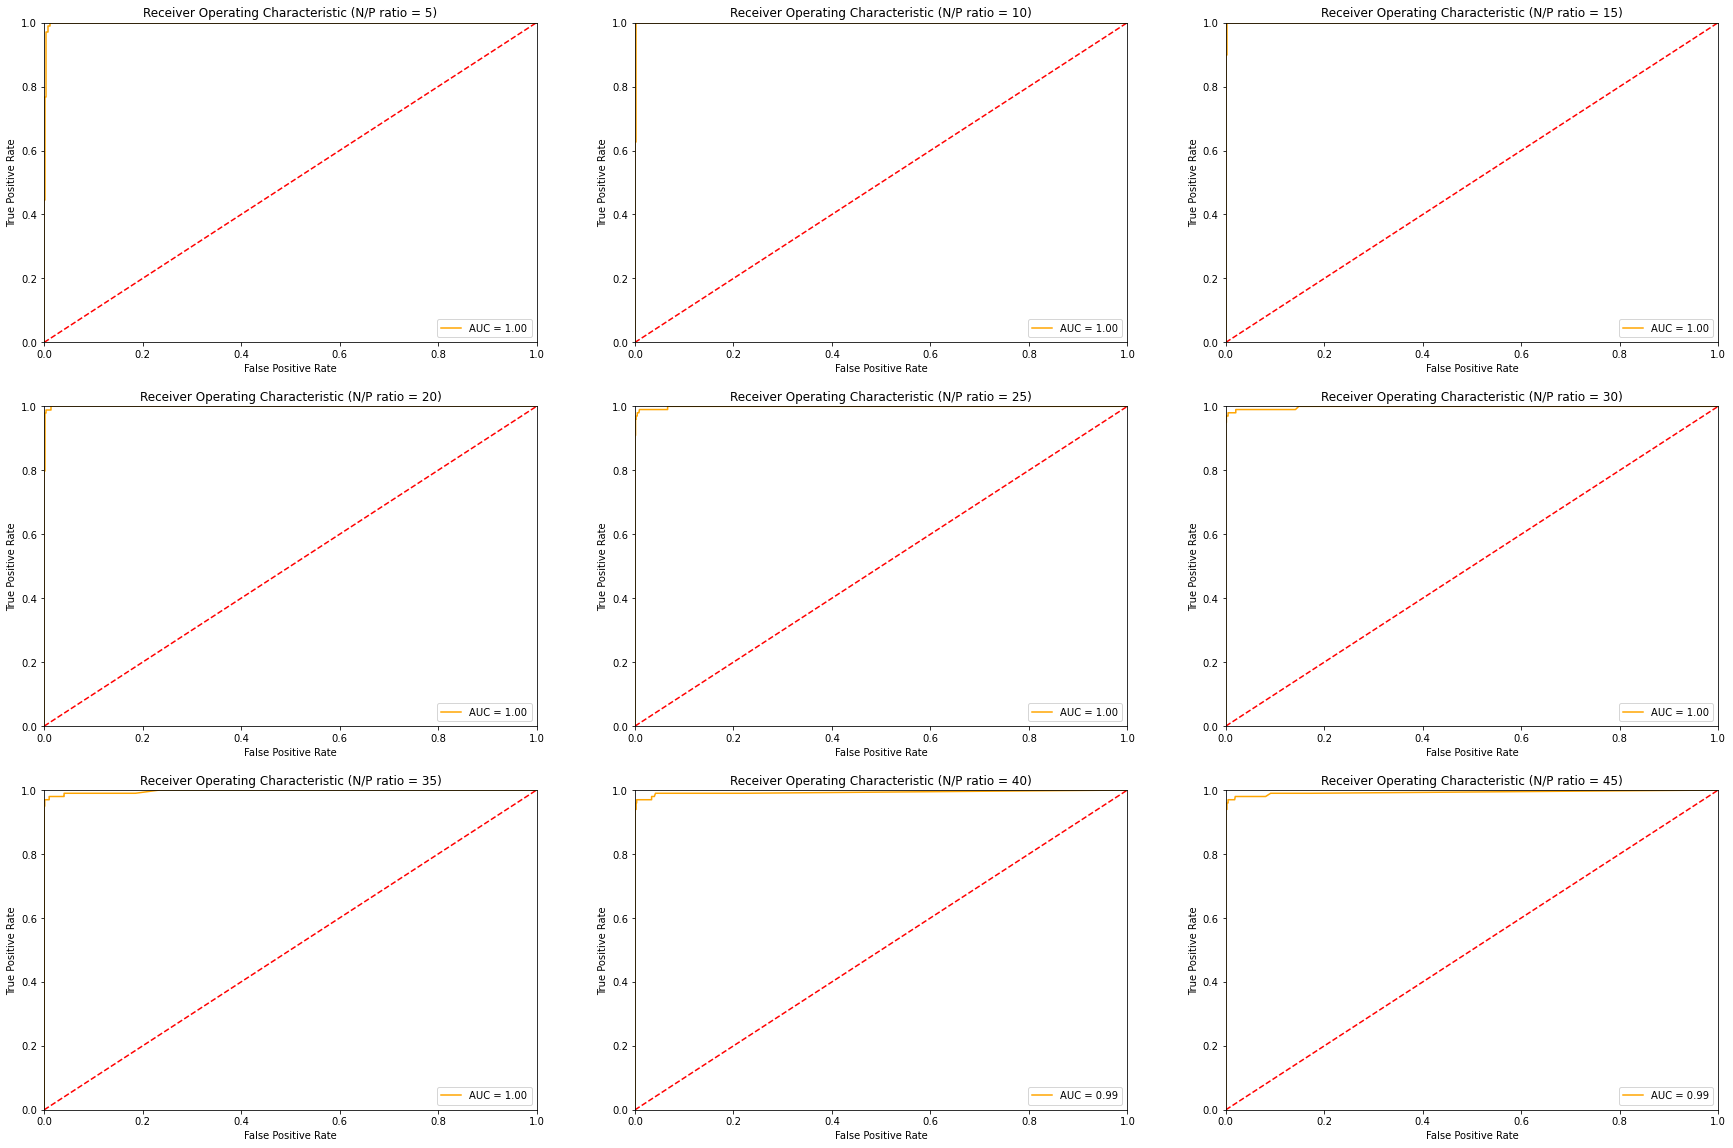

In [17]:
result_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/'
prefix="centroid_based_synthetic_2fold_tumor"

gene_list = list(exp_profile.index)
non_hallmark = list(set(gene_list) -  set(hallmark_gene))
negative = random.sample(non_hallmark,k = 99 * 9)

negative_idx = [gene_list.index(x) for x in gene_list if x in negative ]
pos_idx = [gene_list.index(x) for x in gene_list if x in hallmark_gene ]


npr = np.arange(5,55,5)
fig, axs = plt.subplots(3,3, figsize=(30,20))
axes = axs.ravel()
for idx,ax in enumerate(axes) :

    vote = ensemble_result(result_path+prefix + '/',prefix,0,npr[idx])
    x = np.concatenate([vote[pos_idx],vote[negative_idx]])
    y = np.zeros(99 * 10)
    y[:99] = 1
    df = pd.DataFrame({'actual' : y,'predict' : x})

    fpr, tpr, threshold = roc_curve(df['actual'], df['predict'])
    print(fpr, tpr, threshold)

    auc1 = auc(fpr, tpr)
    ## Plot the result
    ax.set_title('Receiver Operating Characteristic (N/P ratio = ' + str(npr[idx]) + ')')
    ax.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
plt.show()  

### predict hallmark by gene vote number

In [48]:
result_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/'
prefix="centroid_based_synthetic_2fold_tumor"

gene_list = list(exp_profile.index)
non_hallmark = list(set(gene_list) -  set(hallmark_gene))
negative = random.sample(non_hallmark,k = 99 * 9)

negative_idx = [gene_list.index(x) for x in gene_list if x in negative ]
pos_idx = [gene_list.index(x) for x in gene_list if x in hallmark_gene ]

auc = np.zeros(10)
auc_std = np.zeros(10)
recall = np.zeros(10)
recall_std = np.zeros(10)
npr = np.arange(5,55,5)

for idx,np_r in enumerate(npr) :
    vote = ensemble_result(result_path+prefix + '/',prefix,0,np_r)
    x = np.concatenate([vote[pos_idx],vote[negative_idx]]).reshape(-1,1)
    y = np.zeros(99 * 10)
    y[:99] = 1
    clf = LogisticRegression(random_state=0).fit(x, y)
    recall_r = cross_val_score(clf, x, y,cv=5, scoring='recall')
    recall[idx] = np.mean(recall_r)
    recall_std[idx] = np.std(recall_r)
    auc_r = cross_val_score(clf, x, y,cv=5, scoring='roc_auc')
    auc[idx] = np.mean(auc_r)
    auc_std[idx] = np.std(auc_r)


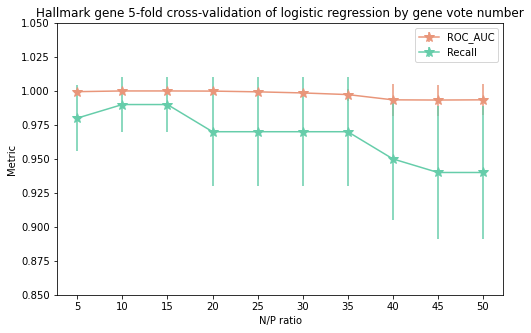

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.errorbar(x = npr,y=auc,yerr=auc_std,marker = '*',color = "darksalmon",ms = 10,label='ROC_AUC')
plt.errorbar(x = npr,y=recall,yerr=recall_std,marker = '*',color = "mediumaquamarine",ms = 10,label='Recall')
plt.xticks(npr)
plt.xlabel('N/P ratio')
plt.ylabel('Metric')
plt.legend()
plt.title('Hallmark gene 5-fold cross-validation of logistic regression by gene vote number')
plt.ylim([0.85,1.05])
plt.savefig('/home/bruce1996/data/LIHC_anomaly_detection/fig/model_performance_by_vote_number.png',dpi = 300)